In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from time import time
from operator import itemgetter

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

PLOT = True
SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots'


In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(5)

CPU times: user 205 ms, sys: 12.2 ms, total: 217 ms
Wall time: 226 ms
(8652, 5) docs shape


,id,titulo,clean,wct,wcc
79,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9,9
80,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8,7
94,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9,7
140,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12,9
141,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7,7


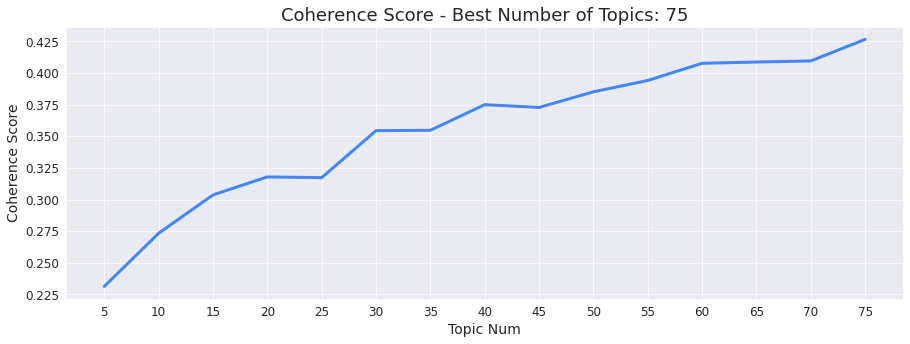

Time: 3.33 mins


In [3]:
# Use Gensim's NMF to get the best num of topics via coherence score

def graph_coherence(texts):
    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(5, 75 + 1, 5))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )
        
        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

    # Plot the results
    fig = plt.figure(figsize=(15, 5))

    plt.plot(topic_nums, coherence_scores, linewidth=3, color='#4287f5')

    plt.title('Coherence Score - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
    plt.xlabel("Topic Num", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
    plt.yticks(fontsize=12)

    file_name = '{}/{}_c_score.png'.format(PLOT_PATH,SELECT_YEAR)
    fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.show()

    return best_num_topics

if PLOT:
    t = time()
    texts = df['clean']
    best_num_topics = graph_coherence(texts)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))
else:
    best_num_topics = 20

In [4]:
# Create the tfidf
texts = df['clean']

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.0025,
    max_df=0.8,
    max_features=5000,
    ngram_range=(1,3),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_fn = tfidf_vectorizer.get_feature_names()

print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



vocabulary: 757
sparse matrix shape: (8652, 757)
nonzero count: 52576
sparsity: 0.803


,term,weight
59,base,0.030003
726,use,0.028411
421,model,0.024984
666,system,0.023598
26,analysi,0.022188
444,network,0.021743
163,data,0.018551
32,approach,0.016796
654,studi,0.014963
364,learn,0.014586


In [5]:
# Run the nmf model
nmf = NMF(
    n_components=20,
    #n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

def list_topics(model, feature_names, no_top_words):
    idx2word = np.array(feature_names)
    for i, topic in enumerate(model.components_):
        print('{:02d}: {}'.format(
            i + 1, ','.join([x for x in idx2word[topic.argsort()[:-no_top_words - 1:-1]]])))

list_topics(nmf,tfidf_fn,8)

01: use,predict,techniqu,estim,improv,identif,measur,3d
02: network,neural,neural network,wireless,sensor,wireless sensor,sensor network,wireless sensor network
03: model,simul,model base,predict,base model,driven,framework,forecast
04: system,control,time,distribut,architectur,multi,inform,support
05: base,featur,model base,base approach,base model,framework,approach base,platform
06: analysi,compar,interact,genom,brazilian,effect,social,social network
07: softwar,develop,product,softwar develop,engin,line,project,product line
08: algorithm,problem,genet,genet algorithm,heurist,parallel,schedul,hybrid
09: data,mine,data mine,stream,data stream,big,visual,big data
10: studi,case,case studi,brazilian,brazil,code,exploratori,compar studi
11: learn,machin,machin learn,environ,educ,learn environ,deep,deep learn
12: evalu,perform,improv,perform evalu,impact,high,design,automat
13: approach,base approach,new,approach base,generat,classif,learn approach,visual
14: method,imag,segment,appli,cl

In [6]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["T%d_words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["T%d_wgt" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(nmf,tfidf_fn,10)


,T0_words,T0_wgt,T1_words,T1_wgt,T2_words,T2_wgt,T3_words,T3_wgt,T4_words,T4_wgt,...,T15_words,T15_wgt,T16_words,T16_wgt,T17_words,T17_wgt,T18_words,T18_wgt,T19_words,T19_wgt
0,use,10.013,network,2.818,model,2.493,system,2.813,base,3.143,...,systemat,1.305,comput,2.369,optim,2.064,detect,2.410,process,2.383
1,predict,1.025,neural,0.889,simul,0.309,control,0.409,featur,0.183,...,review,1.270,cloud,1.195,multi,0.796,anomali,0.225,graph,0.533
2,techniqu,0.722,neural network,0.860,model base,0.177,time,0.229,model base,0.164,...,literatur,0.781,cloud comput,0.682,object,0.680,communiti,0.211,busi,0.441
3,estim,0.585,wireless,0.556,predict,0.146,distribut,0.214,base approach,0.147,...,literatur review,0.629,environ,0.556,multi object,0.399,featur,0.162,busi process,0.362
4,improv,0.568,sensor,0.460,base model,0.142,architectur,0.182,base model,0.147,...,map,0.621,servic,0.444,swarm,0.212,behavior,0.159,support,0.258
5,identif,0.537,wireless sensor,0.404,driven,0.110,multi,0.159,framework,0.140,...,systemat literatur,0.565,secur,0.315,particl,0.209,automat,0.150,mine,0.232
6,measur,0.496,sensor network,0.399,framework,0.107,inform,0.158,approach base,0.126,...,systemat review,0.558,virtual,0.225,particl swarm,0.199,function,0.148,impact,0.182
7,3d,0.446,wireless sensor network,0.359,forecast,0.101,support,0.151,platform,0.124,...,systemat literatur review,0.556,perform,0.218,swarm optim,0.198,code,0.147,manag,0.176
8,time,0.434,convolut,0.349,ontolog,0.099,monitor,0.150,agent,0.123,...,systemat map,0.415,architectur,0.184,particl swarm optim,0.198,chang,0.130,decis,0.168
9,control,0.402,convolut neural network,0.315,estim,0.098,real,0.133,improv,0.116,...,map studi,0.187,awar,0.181,plan,0.176,flow,0.128,tool,0.157


In [7]:
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8
topic_df = topic_table(nmf, tfidf_fn, n_top_words).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(word_tokenize) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


,0,1,2,3,4,5,6,7,topics
0,use,predict,techniqu,estim,improv,identif,measur,3d,use predict techniqu estim improv identif meas...
1,network,neural,neural network,wireless,sensor,wireless sensor,sensor network,wireless sensor network,network neural wireless sensor
2,model,simul,model base,predict,base model,driven,framework,forecast,model simul base predict driven framework fore...
3,system,control,time,distribut,architectur,multi,inform,support,system control time distribut architectur mult...
4,base,featur,model base,base approach,base model,framework,approach base,platform,base featur model approach framework platform


In [8]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head(10)

,topic_num,topics
0,0,use predict techniqu estim improv identif meas...
1,1,network neural wireless sensor
2,2,model simul base predict driven framework fore...
3,3,system control time distribut architectur mult...
4,4,base featur model approach framework platform
5,5,analysi compar interact genom brazilian effect...
6,6,softwar develop product engin line project
7,7,algorithm problem genet heurist parallel sched...
8,8,data mine stream big visual
9,9,studi case brazilian brazil code exploratori c...


In [9]:
df_temp = pd.DataFrame({
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    left_index=True,
    right_index=True
)

df_topics = df_topics.drop(['clean','wct','wcc'],axis=1)
df_topics.head(10)


,id,titulo,topic_num,topics
79,104124422364023,Exploiting photo location and direction for cl...,9,studi case brazilian brazil code exploratori c...
80,104124422364023,A gold-standard social media corpus for urban ...,15,systemat review literatur map
94,104124422364023,A Framework for Spatial Analytics using Hetero...,5,analysi compar interact genom brazilian effect...
140,105670521813027,Gene expression analysis in Musa acuminata dur...,18,detect anomali communiti featur behavior autom...
141,105670521813027,Mitogenome sequence accuracy using different e...,10,learn machin environ educ deep
169,109837868064895,A study of equivalent electrical circuit fitti...,11,evalu perform improv impact high design automat
210,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,13,method imag segment appli classif automat asse...
211,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,8,data mine stream big visual
212,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,14,applic mobil design awar context cost energi test
242,116792663386170,Removal of amoxicillin from water by adsorptio...,19,process graph busi support mine impact manag


In [10]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 8652 x 757
W = 20 x 757
H = 8652 x 20


In [11]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 8272.121'

In [12]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = '/{}_avg_resid'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

ValueError: Length of values does not match length of index

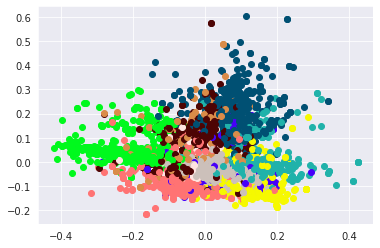

<Figure size 1080x504 with 0 Axes>

Time: 5.25 mins


In [13]:
# Create k-means model with custom config

def graph_KMeans(tfidf):
    num_clusters = 10
    num_seeds = 10
    max_iterations = 300
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
        5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
    pca_num_components = 2

    clustering_model = KMeans(
        n_clusters=num_clusters,
        max_iter=max_iterations,
        precompute_distances="auto",
        n_jobs=-1
    )

    labels = clustering_model.fit_predict(tfidf)

    X = tfidf.todense()

    reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

    fig = plt.figure(figsize=(15, 7))

    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_data):
        pca_comp_1, pca_comp_2 = reduced_data[index]
        color = labels_color_map[labels[index]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color)

    file_name = '{}/{}_KMeans.png'.format(PLOT_PATH,SELECT_YEAR)
    fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.show()

if PLOT:
    t = time()
    graph_KMeans(tfidf)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

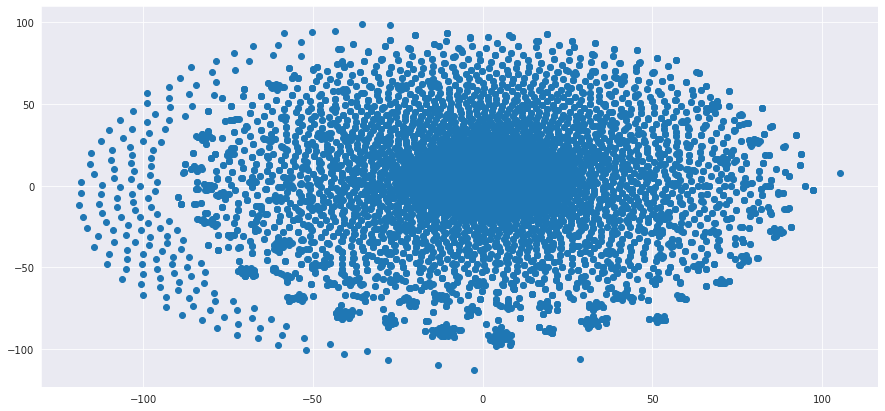

Time: 3.04 mins


In [14]:
# t-SNE plot

def graph_tsne(tfidf):
    X = tfidf.todense()
    tsne_num_components = 2
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)

    fig = plt.figure(figsize=(15, 7))

    plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)

    file_name = '{}/{}_tsne.png'.format(PLOT_PATH,SELECT_YEAR)
    fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.show()

if PLOT:
    t = time()
    graph_tsne(tfidf)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))


In [15]:
# Save
path = '{}/'.format(DATA_PATH)

topics_file = '{}/{}_topics.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df_topics.to_pickle(topics_file, compression='xz')

CPU times: user 24.3 ms, sys: 17 ms, total: 41.3 ms
Wall time: 49.9 ms
